In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import *
π = pi
import matplotlib.animation as mplanim 
plt.rc('animation', html='jshtml')
from typing import Callable
from scipy import integrate
from scipy import optimize
import scipy.special as ss
from mpl_toolkits.axes_grid1 import AxesGrid
from tqdm.notebook import tqdm
import os
#%config InlineBackend.figure_formats = ['svg']
plt.rcParams['mpl_toolkits.legacy_colorbar'] = False
import colorsys

# General functions

In [2]:
def ωn (β:float, n:int) -> float:
    return (2*n+1)*π / β

def greenmatsubara_time_to_freq (β:float, dτ:float, Gτ:np.array) -> Callable[[int],complex]:
    τ = np.arange(0, β+1e-10, dτ)
    # between 0 and β integrate G(τ) exp(i.ωn.τ)
    f = lambda n: dτ * np.sum( np.exp(1j*ωn(β,n)*τ) * Gτ )
    return np.vectorize(f)

def greenmatsubara_freq_to_time_sing (β:float, iωn:np.array, Giωn_sing:np.array, halfiωn=False) -> Callable[[float],float]:
    # if halfiωn=False, Giωn should have an even size 2N, corresponding to n's in [-n,n[ (eg. [-1,0], [-2,-1,0,1]...)
    #                   ( n = np.arange(-len(Giωn_sing)//2, len(Giωn_sing)//2) )
    # if halfiωn=True, Giωn should have a size N, corresponding to n's in [0,N[
    if halfiωn:
        f = lambda τ: 2/β * np.sum( np.real( np.exp(-iωn*τ) * Giωn_sing ) ) + (-1/2 if τ>=0 else +1/2)
    else:
        f = lambda τ: 1/β * np.sum(          np.exp(-iωn*τ) * Giωn_sing )   + (-1/2 if τ>=0 else +1/2)
    return np.vectorize(f)

def greenfunc_forget_negfreq (Giωn, iωn=None, n=None):
    N = len(Giωn)//2
    if n is None:
        if iωn is None:
            return Giωn[N:]
        else:
            return Giωn[N:], iωn[N:]
    else:
        return Giωn[N:], iωn[N:], n[N:]

def greenfunc_extend_negfreq (Giωn):
    N = len(Giωn)
    Giωn_new = np.zeros(2*N, dtype=np.complex128)
    Giωn_new[N:] = Giωn
    Giωn_new[:N] = np.flip( np.real(Giωn) -1j * np.imag(Giωn) )
    n = np.arange(-N,N)
    iωn = 1j*ωn(β,n)
    return Giωn_new, iωn, n

In [3]:
def Giωn_at (β, iωn, U):
    return 1/2 / ( iωn - U/2 ) + 1/2 / ( iωn + U/2 )

def Gτ_at (β, τ, U):
    return -1/2 * np.exp(-τ*U/2) / ( np.exp(-β*U/2) + 1 ) -1/2 * np.exp(+τ*U/2) / ( np.exp(+β*U/2) + 1 )

def G0_loc_iωn (latt_hilbert, iωn, µ):
    return latt_hilbert(iωn+µ)

In [4]:
def plot_Gτ_without_discont (Gτ_f, τ, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    pos = np.where(τ >= 0)[0][0]
    Gτ = np.insert(np.real(Gτ_f(τ)), pos, np.nan)
    τ = np.insert(τ, pos, np.nan)
    ax.plot(τ,Gτ,**kwargs)

In [5]:
# t = 1 implicitely here, for the Bethe lattice

def latt_Bethe_DoS (ϵ:float) -> float:
    return 1/(2*π) * np.sqrt(4-ϵ**2)

def latt_Bethe_hilbert (z:complex) -> complex:
    s = np.sign(np.imag(z))
    return ( z - 1j*s*np.sqrt(4 - z**2) ) /2

def latt_Bethe_R (η:complex) -> complex:
#    if np.any(np.abs(η)>1):
#        raise ValueError("the reciprocal Hilbert transform for the Bethe lattice is defined only on {|z|<1}")
    return η + 1/η

In [6]:
# eq (self-consistent-eq-reciproc-Hilbert-fromcavity)

def imp_Gbath_from_Gloc (R:Callable[[complex],complex], iωn:np.array, Gloc_iωn:np.array, µ:float) -> np.array:
    return 1 /( iωn + µ + 1/Gloc_iωn - R(Gloc_iωn) )

# IPT DMFT loop

In [7]:
def impurity_solver_IPT (β:float, U:float, iωn:np.array, Gbath_iωn:np.array, dτ=1e-3, halfiωn=False) -> Callable[[int],complex]:
    # Gbath_iωn should have an even size 2N, corresponding to n's in [-N,N[ (eg. [-1,0], [-2,-1,0,1]...)
    Gbath_shift_iωn = 1/( 1/Gbath_iωn - U/2 )
    τ = np.arange(0, β+1e-10, dτ)
    Gbath_shift_τ = greenmatsubara_freq_to_time_sing(β, iωn, Gbath_shift_iωn-1/iωn, halfiωn)
    Gbath_shift_τ = Gbath_shift_τ(τ)
                                   # between 0 and β integrate G(τ)^3 exp(i.ωn.τ)
    f = lambda n: U/2 + U**2 * dτ * np.sum( np.exp(1j*ωn(β,n)*τ) * Gbath_shift_τ**3 )
    return np.vectorize(f)#, τ, Gbath_shift_τ

In [8]:
def plot_Giωn (ax, G_iωn, name="G", twinx_im=False, halfiωn=False, zoom_on=None):
    N = len(G_iωn) if halfiωn else len(G_iωn)//2
    n = np.arange(0,N) if halfiωn else np.arange(-N,N)
    if zoom_on is None:
        zoom_on = N
    mask = ( np.abs(n) <= zoom_on )
    if twinx_im:
        ax_im = ax.twinx()
    else:
        ax_im = ax
    ax_im.plot(n[mask], np.imag(G_iωn)[mask], '.--', lw=1, label='im. part', color='blue')
    ax.plot   (n[mask], np.real(G_iωn)[mask], '.--', lw=1, label='re. part', color='orange')
    ax.set_xlabel("$n$")
    ax.set_title("$"+name+r"(i\omega_n)$")
    ax.legend(loc='upper left')
    if twinx_im:
        ax_im.legend(loc='upper right')
        m = 1.5 * np.max(np.abs(np.real(G_iωn)))
        ax.set_ylim((-m,+m))
        
def DMFT_loop_Gloc (β, U, latt_R, Gloc_iωn_0, conv_thresh=1e-5, γ=0.9, callback=None, internal_halfiωn=False, discard_real_part=0, IPT_dτ=1e-3):
    µ = U/2
    n = np.arange(-len(Gloc_iωn_0)//2,len(Gloc_iωn_0)//2)
    iωn = 1j*ωn(β,n)
    Gloc_iωn = Gloc_iωn_0
    if internal_halfiωn:
        Gloc_iωn, iωn, n = greenfunc_forget_negfreq(Gloc_iωn_0, iωn, n)

    maxit = max(100,int(β))
    for it in range(maxit):

        # DMFT loop
        Gbath_iωn = imp_Gbath_from_Gloc (latt_Bethe_R, iωn, Gloc_iωn, µ)
        Σloc_iωn = impurity_solver_IPT (β, U, iωn, Gbath_iωn, dτ=IPT_dτ, halfiωn=internal_halfiωn)
        Σloc_iωn = Σloc_iωn(n)
        Gloc_iωn_new = latt_Bethe_hilbert( iωn + µ - Σloc_iωn )
        # or : Gloc_iωn_new = 1 / ( 1/Gbath_iωn - Σloc_iωn )
        Gloc_iωn_new -= discard_real_part * np.real(Gloc_iωn_new)

        norm1_diff = np.linalg.norm(Gloc_iωn-Gloc_iωn_new, ord=1)
        if callback is not None:
            callback(it,iωn,Σloc_iωn,Gloc_iωn_new,norm1_diff)
        if norm1_diff < conv_thresh:
            Gloc_iωn = Gloc_iωn_new
            break
        Gloc_iωn = (1-γ) * Gloc_iωn + γ * Gloc_iωn_new
    
    if it == maxit-1:
        raise RuntimeError("DMFT loop did not converge")
    if internal_halfiωn:
        return µ, greenfunc_extend_negfreq(Gloc_iωn)[0], greenfunc_extend_negfreq(Σloc_iωn)[0], greenfunc_extend_negfreq(Gbath_iωn)[0]
    else:
        return µ, Gloc_iωn, Σloc_iωn, Gbath_iωn

In [9]:
def cb_print_delta (it, iωn, Σloc_iωn, Gloc_iωn_new, norm1_diff):
    n = len(iωn)//2
    deriv0 = (Σloc_iωn[n+1] - Σloc_iωn[n]).imag / (iωn[n+1] - iωn[n]).imag
    print("L1delta",norm1_diff,"; deriv0 ",deriv0)

### Example of bistability
(initial condition matters)

L1delta 5.6514897887023166 ; deriv0  0.017697157258103526
L1delta 0.8465220557265809 ; deriv0  0.017987629369493927
L1delta 0.28030421329698424 ; deriv0  0.017986428216776
L1delta 0.07393347961573332 ; deriv0  0.01800030008978053
L1delta 0.029159489803079246 ; deriv0  0.018001816638356743
L1delta 0.00940486614031092 ; deriv0  0.018003345135251165
L1delta 0.0038604602428453996 ; deriv0  0.01800370240234938
L1delta 0.0013702648626914664 ; deriv0  0.018003915295470737
L1delta 0.0005681200615188231 ; deriv0  0.01800398148085629
L1delta 0.00021245203530950024 ; deriv0  0.0180040137018074
L1delta 8.794185344785516e-05 ; deriv0  0.01800402510875059
L1delta 3.389239272582126e-05 ; deriv0  0.018004030166753567
L1delta 1.3955359008586271e-05 ; deriv0  0.018004032074795707
L1delta 5.476310008266372e-06 ; deriv0  0.018004032882922526


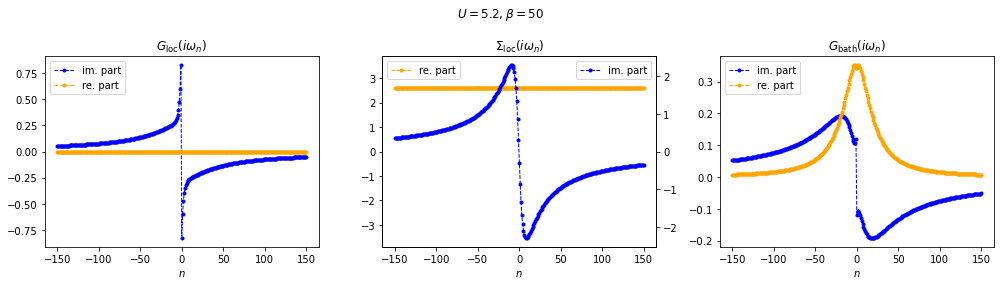

In [25]:
β = 50
U = 5.2
iωn = 1j*ωn(β,np.arange(-300,+300))
Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)     # metallic initial condition
#Gloc_iωn_0 = Giωn_at(β, iωn, U)        # atomic limit initial condition

µ, Gloc_iωn, Σloc_iωn, Gbath_iωn = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=1.3, conv_thresh=1e-5, discard_real_part=1, callback=cb_print_delta, IPT_dτ=5e-3, internal_halfiωn=True)

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(14,4))
plot_Giωn(ax1, Gloc_iωn, "G_\operatorname{loc}", zoom_on=150)
plot_Giωn(ax2, Σloc_iωn, "\Sigma_\operatorname{loc}", twinx_im=True, zoom_on=150)
plot_Giωn(ax3, Gbath_iωn, "G_\operatorname{bath}", zoom_on=150)
fig.suptitle(r"$U={}, \beta={}$".format(U,β))
fig.tight_layout()

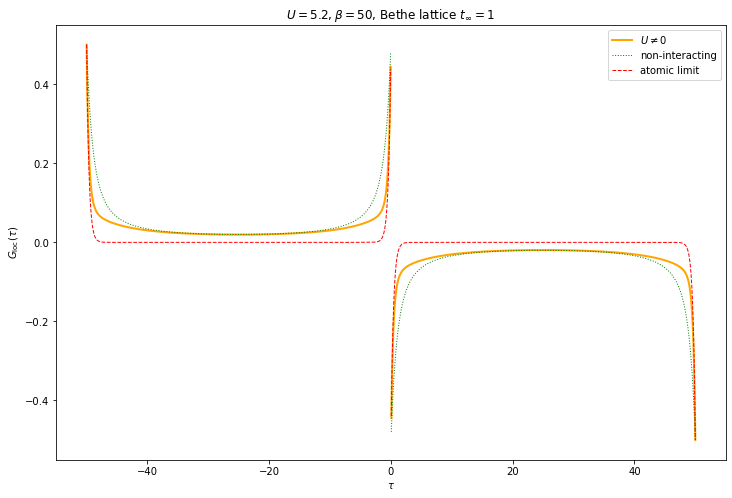

In [613]:
def plot_Gtau_compare (iωn, Gloc_iωn, latt_hilbert, β, U):

    plt.figure(figsize=(12,8))
    τ = np.linspace(-β,β,1000)

    Gloc_tau = greenmatsubara_freq_to_time_sing(β, iωn, Gloc_iωn-1/iωn)
    plot_Gτ_without_discont(Gloc_tau, τ, label=r"$U\neq 0$", color='orange', lw=2)

    Gloc_tau = greenmatsubara_freq_to_time_sing(β, iωn, G0_loc_iωn(latt_hilbert, iωn, 0) -1/iωn)
    plot_Gτ_without_discont(Gloc_tau, τ, label=r"non-interacting", lw=1, linestyle='dotted', color="green")

    Gloc_tau = greenmatsubara_freq_to_time_sing(β, iωn, Giωn_at(β, iωn, U) -1/iωn)
    plot_Gτ_without_discont(Gloc_tau, τ, label=r"atomic limit", lw=1, linestyle='--', color="red")

    plt.title(r"$U={}, \beta={}$, Bethe lattice $t_\infty=1$".format(U,β))
    plt.ylabel(r"$G_\operatorname{loc}(\tau)$")
    plt.xlabel(r"$\tau$")
    plt.legend()

plot_Gtau_compare(iωn, Gloc_iωn, latt_Bethe_hilbert, β, U)

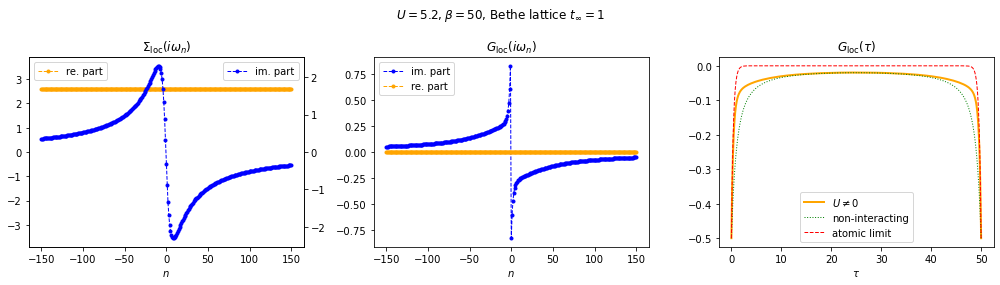

In [38]:
fig, (ax2,ax1,ax3) = plt.subplots(ncols=3, figsize=(14,4))
plot_Giωn(ax1, Gloc_iωn, "G_\operatorname{loc}", zoom_on=150)
plot_Giωn(ax2, Σloc_iωn, "\Sigma_\operatorname{loc}", twinx_im=True, zoom_on=150)

τ = np.linspace(0,β,1000)

Gloc_tau = greenmatsubara_freq_to_time_sing(β, iωn, Gloc_iωn-1/iωn)
plot_Gτ_without_discont(Gloc_tau, τ, ax=ax3, label=r"$U\neq 0$", color='orange', lw=2)

Gloc_tau = greenmatsubara_freq_to_time_sing(β, iωn, G0_loc_iωn(latt_Bethe_hilbert, iωn, 0) -1/iωn)
plot_Gτ_without_discont(Gloc_tau, τ, ax=ax3, label=r"non-interacting", lw=1, linestyle='dotted', color="green")

Gloc_tau = greenmatsubara_freq_to_time_sing(β, iωn, Giωn_at(β, iωn, U) -1/iωn)
plot_Gτ_without_discont(Gloc_tau, τ, ax=ax3, label=r"atomic limit", lw=1, linestyle='--', color="red")

ax3.set_title(r"$G_\operatorname{loc}(\tau)$")
ax3.set_xlabel(r"$\tau$")
ax3.legend()

fig.suptitle(r"$U={}, \beta={}$, Bethe lattice $t_\infty=1$".format(U,β))
fig.tight_layout()
plt.savefig("U52-beta50-sigmaiwn-Giwn-Gtau-metal.pdf")

L1delta 0.6959663233732664 ; deriv0  0.018243926600657913
L1delta 0.13664772574901107 ; deriv0  0.018205552676522904
L1delta 0.053693802834612815 ; deriv0  0.018196305156743742
L1delta 0.019780666324406313 ; deriv0  0.01819207161256161
L1delta 0.011284104400007603 ; deriv0  0.018189533342905653
L1delta 0.006131176984104175 ; deriv0  0.018188112001050624
L1delta 0.003993701812074715 ; deriv0  0.018187102425847475
L1delta 0.002743384017011616 ; deriv0  0.01818642808610829
L1delta 0.0019422382212766556 ; deriv0  0.018185923820763294
L1delta 0.0014727140798246469 ; deriv0  0.018185550574380337
L1delta 0.001120904343534141 ; deriv0  0.018185260488724635
L1delta 0.0008885260380453106 ; deriv0  0.018185033098768448
L1delta 0.0007091976354601758 ; deriv0  0.018184850573857072
L1delta 0.0005780166325848532 ; deriv0  0.018184702403686324
L1delta 0.00047540144961037353 ; deriv0  0.018184580457805157
L1delta 0.0003956815098808894 ; deriv0  0.018184479147697604
L1delta 0.0003319261417951587 ; deriv

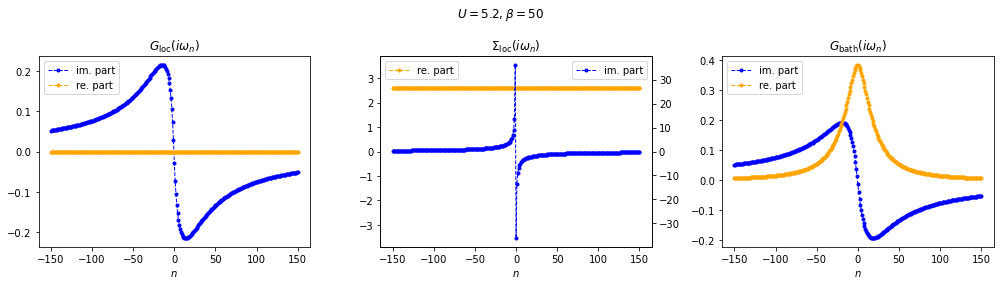

In [39]:
β = 50
U = 5.2
iωn = 1j*ωn(β,np.arange(-300,+300))
#Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)     # metallic initial condition
Gloc_iωn_0 = Giωn_at(β, iωn, U)        # atomic limit initial condition

µ, Gloc_iωn, Σloc_iωn, Gbath_iωn = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=1.4, conv_thresh=1e-4, discard_real_part=1, callback=cb_print_delta, IPT_dτ=5e-3, internal_halfiωn=True)

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(14,4))
plot_Giωn(ax1, Gloc_iωn, "G_\operatorname{loc}", zoom_on=150)
plot_Giωn(ax2, Σloc_iωn, "\Sigma_\operatorname{loc}", twinx_im=True, zoom_on=150)
plot_Giωn(ax3, Gbath_iωn, "G_\operatorname{bath}", zoom_on=150)
fig.suptitle(r"$U={}, \beta={}$".format(U,β))
fig.tight_layout()

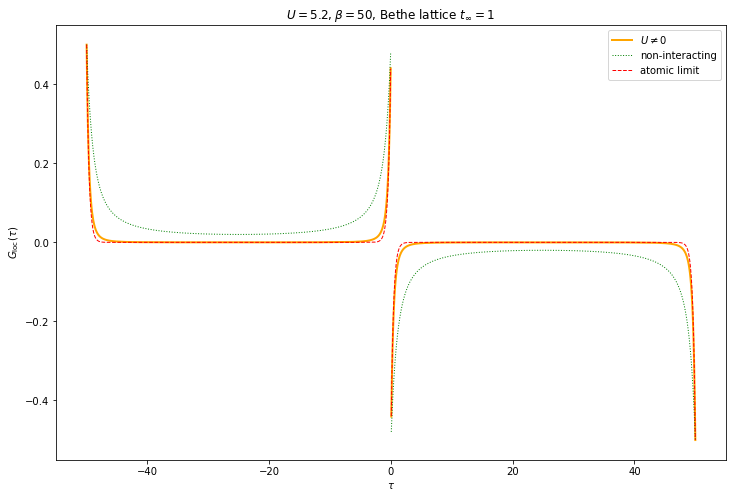

In [603]:
plot_Gtau_compare(iωn, Gloc_iωn, latt_Bethe_hilbert, β, U)

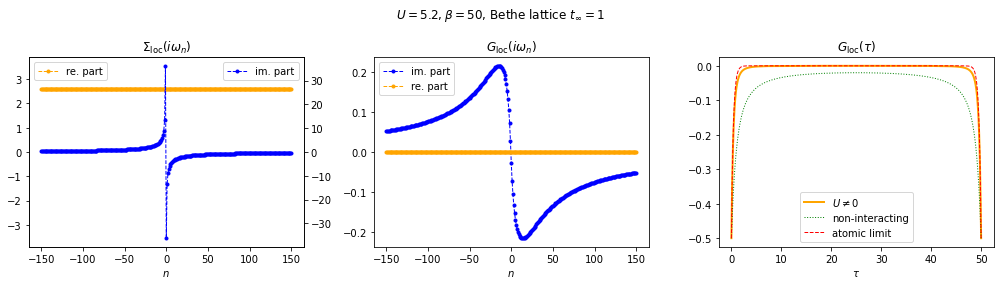

In [40]:
fig, (ax2,ax1,ax3) = plt.subplots(ncols=3, figsize=(14,4))
plot_Giωn(ax1, Gloc_iωn, "G_\operatorname{loc}", zoom_on=150)
plot_Giωn(ax2, Σloc_iωn, "\Sigma_\operatorname{loc}", twinx_im=True, zoom_on=150)

τ = np.linspace(0,β,1000)

Gloc_tau = greenmatsubara_freq_to_time_sing(β, iωn, Gloc_iωn-1/iωn)
plot_Gτ_without_discont(Gloc_tau, τ, ax=ax3, label=r"$U\neq 0$", color='orange', lw=2)

Gloc_tau = greenmatsubara_freq_to_time_sing(β, iωn, G0_loc_iωn(latt_Bethe_hilbert, iωn, 0) -1/iωn)
plot_Gτ_without_discont(Gloc_tau, τ, ax=ax3, label=r"non-interacting", lw=1, linestyle='dotted', color="green")

Gloc_tau = greenmatsubara_freq_to_time_sing(β, iωn, Giωn_at(β, iωn, U) -1/iωn)
plot_Gτ_without_discont(Gloc_tau, τ, ax=ax3, label=r"atomic limit", lw=1, linestyle='--', color="red")

ax3.set_title(r"$G_\operatorname{loc}(\tau)$")
ax3.set_xlabel(r"$\tau$")
ax3.legend()

fig.suptitle(r"$U={}, \beta={}$, Bethe lattice $t_\infty=1$".format(U,β))
fig.tight_layout()
plt.savefig("U52-beta50-sigmaiwn-Giwn-Gtau-insulator.pdf")

# Phase diagram

Based on quasi-particule weight :

In [10]:
def quasipart_z (iωn, Σloc_iωn):
    n = len(iωn)//2
    deriv0 = (Σloc_iωn[n+1] - Σloc_iωn[n]).imag / (iωn[n+1] - iωn[n]).imag
    if deriv0 > 0:
        return np.nan
    else:
        return 1/(1-deriv0)

### Metallic initial state, no $\mathrm{i}\omega_n$ sym. constraint, no $\Re\mathfrak{e}\ G_\text{loc}(\mathrm{i}\omega_n)$ constraint

In [11]:
U_s = np.linspace(0.25,7,28)
β_s = [1,2,2.5,4,5,6.25,10,20,50,100,200]
Z_from_metal = np.zeros((len(β_s),len(U_s)))
ΣlocL2_from_metal = np.zeros((len(β_s),len(U_s)))
norm1_real = np.zeros((len(β_s),len(U_s)))
n_max = 300

for u,U in enumerate(U_s):
    for i,β in enumerate(β_s):
        filename = "data_bethe_from_metal/U{}-beta{}.npz".format(U,β)
        if os.path.exists(filename):
            f = np.load(filename)
            iωn, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']
            norm1_real[i,u] = np.linalg.norm(np.real(Gloc_iωn),ord=1)
        else:
            n = np.arange(-n_max,+n_max)
            iωn = 1j*ωn(β,n)
            Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)
            _, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=0.9, conv_thresh=1e-4)
            np.savez(filename, n=n, iwn=iωn, Gloc=Gloc_iωn, Sigmaloc=Σloc_iωn)
        Z_from_metal[i,u] = quasipart_z (iωn, Σloc_iωn)
        ΣlocL2_from_metal[i,u] = np.linalg.norm(np.imag(Σloc_iωn),ord=2)

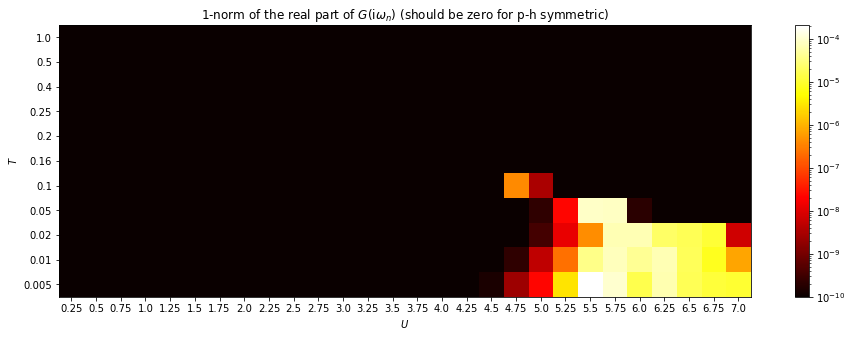

In [12]:
plt.figure(figsize=(16,5))
plt.imshow(norm1_real, cmap='hot', origin='upper', norm=mpl.colors.LogNorm(vmin=1e-10))
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("1-norm of the real part of $G(\mathrm{i}\omega_n)$ (should be zero for p-h symmetric)");

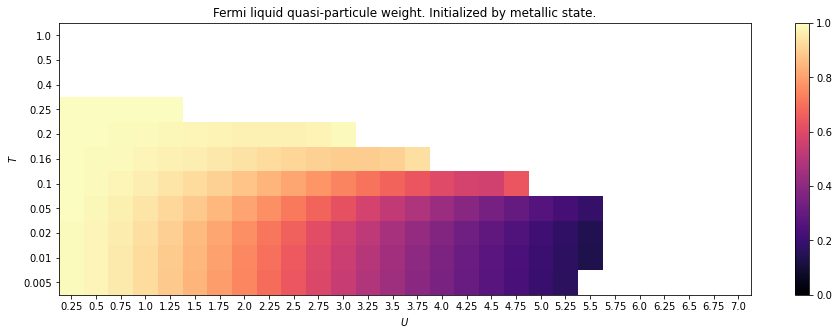

In [13]:
plt.figure(figsize=(16,5))
plt.imshow(Z_from_metal, vmax=1, vmin=0, cmap='magma', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("Fermi liquid quasi-particule weight. Initialized by metallic state.");

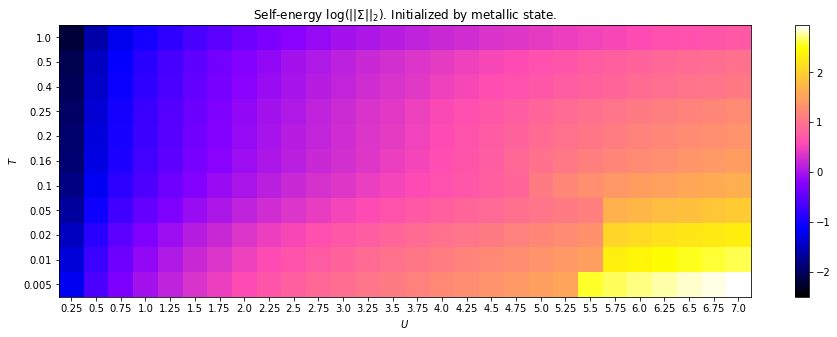

In [14]:
plt.figure(figsize=(16,5))
plt.imshow(np.log10(ΣlocL2_from_metal+1e-10), vmin=-2.5, cmap='gnuplot2', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title(r"Self-energy $\log(||\Sigma||_2)$. Initialized by metallic state.");

### Atomic limit initial state, no $\mathrm{i}\omega_n$ sym. constraint, no $\Re\mathfrak{e}\ G_\text{loc}(\mathrm{i}\omega_n)$ constraint

In [15]:
U_s = np.linspace(0.25,7,28)
β_s = [1,2,2.5,4,5,6.25,10,20,50,100,200]
Z_from_atomiclim = np.zeros((len(β_s),len(U_s)))
norm1_real = np.zeros((len(β_s),len(U_s)))
n_max = 300

for i,β in enumerate(β_s):
    for u,U in enumerate(U_s):
        filename = "data_bethe_from_atomiclim/U{}-beta{}.npz".format(U,β)
        if os.path.exists(filename):
            f = np.load(filename)
            iωn, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']
            norm1_real[i,u] = np.linalg.norm(np.real(Gloc_iωn),ord=1)
        else:
            n = np.arange(-n_max,+n_max)
            iωn = 1j*ωn(β,n)
            Gloc_iωn_0 = Giωn_at(β, iωn, U)
            _, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=0.9, conv_thresh=1e-4)
            np.savez(filename, n=n, iwn=iωn, Gloc=Gloc_iωn, Sigmaloc=Σloc_iωn)
        Z_from_atomiclim[i,u] = quasipart_z (iωn, Σloc_iωn)

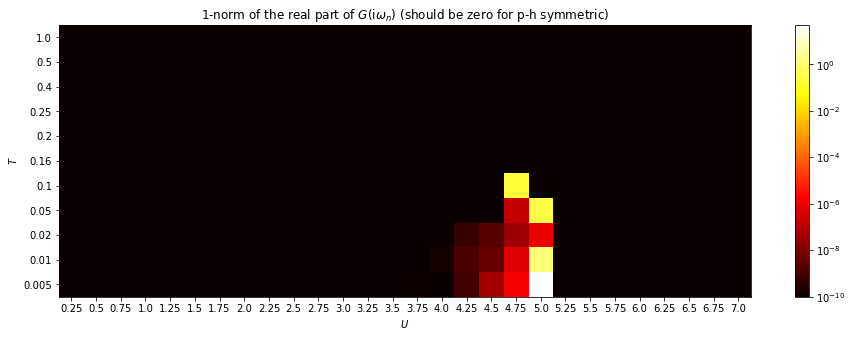

In [16]:
plt.figure(figsize=(16,5))
plt.imshow(norm1_real, cmap='hot', origin='upper', norm=mpl.colors.LogNorm(vmin=1e-10))
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("1-norm of the real part of $G(\mathrm{i}\omega_n)$ (should be zero for p-h symmetric)");

In [17]:
for i,β in enumerate(β_s):
    for u,U in enumerate(U_s):
        if norm1_real[i,u] < 1e-10:
            continue
            
#        print(β,U,"is at",norm1_real[i,u])
        filename = "data_bethe_from_atomiclim_correct-real0/U{}-beta{}.npz".format(U,β)
        if os.path.exists(filename):
            f = np.load(filename)
            iωn, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']
            
        else:
            n = np.arange(-n_max,+n_max)
            iωn = 1j*ωn(β,n)
            Gloc_iωn_0 = Giωn_at(β, iωn, U)
            
            def cb_reg_real_part (it, iωn, Σloc_iωn, Gloc_iωn_new, norm1_diff):
                r = np.linalg.norm(np.real(Gloc_iωn_new),ord=1)
                print("L1delta",norm1_diff,"; L1real",r)
                if False:
           #         fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(16,5))
                    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))
                    fig.suptitle(r"Init. increasing $U$, $U={}, \beta={}$. DMFT loop iter {}, $||Re(G)||_1={:.2e}$".format(U,β,it,r))
                    plot_Giωn(ax1, greenfunc_extend_negfreq(Σloc_iωn)[0], "\Sigma_\operatorname{loc}", twinx_im=True)
                    ax1.set_ylim((-4,4))
                    plot_Giωn(ax2, greenfunc_extend_negfreq(Gloc_iωn_new)[0], "G_\operatorname{loc}")
                    ax2.set_ylim((-1.1,1.1))
           #         ax3.plot(τ, np.real(Gbath_shift_τ), color='red', label='real part')
           #         ax3.plot(τ, np.imag(Gbath_shift_τ), color='cornflowerblue', label='imag part')
           #         ax3.legend()
           #         ax3.set_ylim((-0.55,0.05))
           #         ax3.set_title(r"$G_\operatorname{bath}(\tau)$")
           #         ax3.set_xlabel(r"$\tau$")
                    fig.tight_layout()
           #         plt.savefig("anim2/{}.png".format(it), bbox_inches='tight')
                    plt.show()
                # gently forcing the real part to be zero, **but only if we are nearly converged**
                # else the hysteresis effect can be very large, up to the point that no transition happens...
                if norm1_diff < 1e-5 or it > 50:
                    c = 0.1 * max(1,min(9,log10(r)+20))
                    print(c)
                    Gloc_iωn_new -= np.real(Gloc_iωn_new) * c
                Gloc_iωn_new -= 0.01 * np.real(Gloc_iωn_new)
                
            _, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn, γ=0.9, conv_thresh=2e-7, callback=cb_reg_real_part, internal_halfiωn=True)
            plot_Giωn(plt.gca(), Σloc_iωn, "\Sigma_\operatorname{loc}", twinx_im=True)
            plt.show()
            
            np.savez(filename, n=n, iwn=iωn, Gloc=Gloc_iωn, Sigmaloc=Σloc_iωn)
            
        Z_from_atomiclim[i,u] = quasipart_z (iωn, Σloc_iωn)

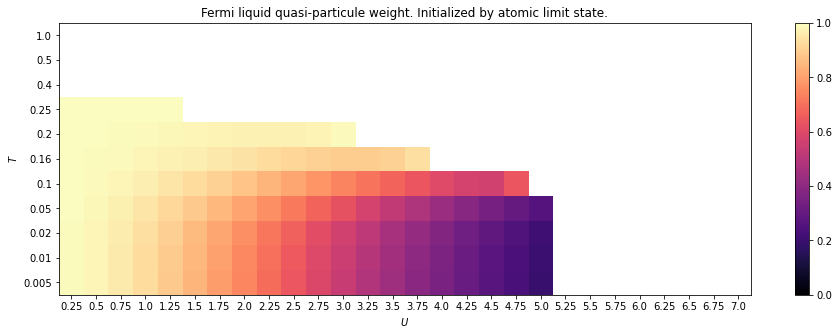

In [18]:
plt.figure(figsize=(16,5))
plt.imshow(Z_from_atomiclim, vmax=1, vmin=0, cmap='magma', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("Fermi liquid quasi-particule weight. Initialized by atomic limit state.");

### Scanning by increasing $U$, no $\mathrm{i}\omega_n$ sym. constraint, no $\Re\mathfrak{e}\ G_\text{loc}(\mathrm{i}\omega_n)$ constraint

In [19]:
U_s = np.linspace(0.25,7,28)
β_s = [1,2,2.5,4,5,6.25,10,20,50,100,200]
Z_increasingU = np.zeros((len(β_s),len(U_s)))
norm1_real = np.zeros((len(β_s),len(U_s)))
n_max = 300

for i,β in enumerate(β_s):
    n = np.arange(-n_max,+n_max)
    iωn = 1j*ωn(β,n)
    Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)
    for u,U in enumerate(U_s):
        filename = "data_bethe_increasingU/U{}-beta{}.npz".format(U,β)
        if os.path.exists(filename):
            f = np.load(filename)
            _, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']
            norm1_real[i,u] = np.linalg.norm(np.real(Gloc_iωn),ord=1)
        else:
            _, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=0.9, conv_thresh=1e-4)
            np.savez(filename, n=n, iwn=iωn, Gloc=Gloc_iωn, Sigmaloc=Σloc_iωn)
        Gloc_iωn_0 = np.copy(Gloc_iωn)
        Z_increasingU[i,u] = quasipart_z (iωn, Σloc_iωn)

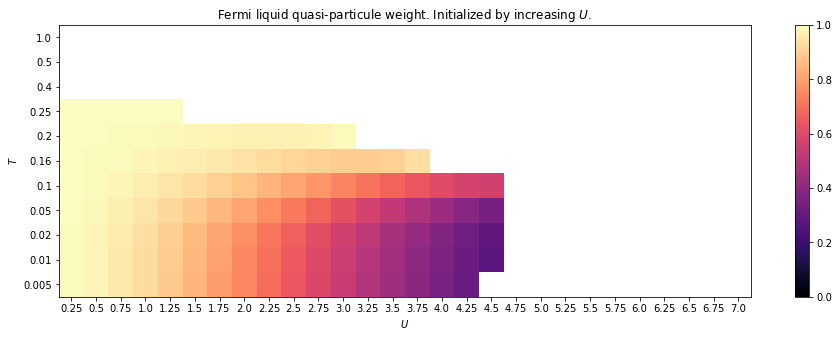

In [20]:
plt.figure(figsize=(16,5))
plt.imshow(Z_increasingU, vmax=1, vmin=0, cmap='magma', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("Fermi liquid quasi-particule weight. Initialized by increasing $U$.");

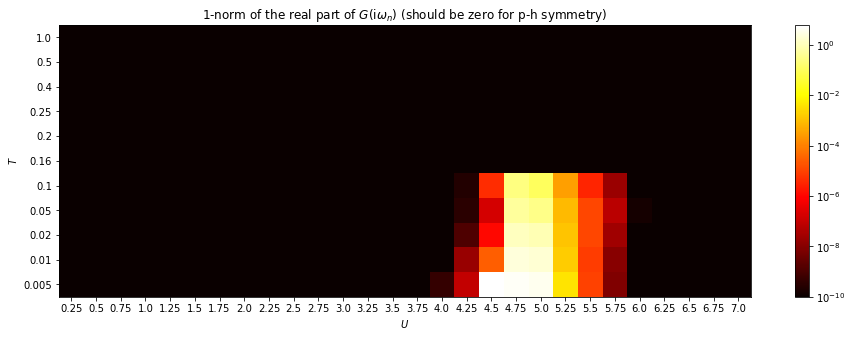

In [22]:
plt.figure(figsize=(16,5))
plt.imshow(norm1_real, cmap='hot', origin='upper', norm=mpl.colors.LogNorm(vmin=1e-10))
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("1-norm of the real part of $G(\mathrm{i}\omega_n)$ (should be zero for p-h symmetry)")
plt.savefig("real-part-norm-increasingU.pdf", bbox_inches='tight')

Well, there's a stability issue for some $(\beta,U)$'s, especially at low temperature and close-to-transition $U$'s : the real part does not want to be zero. Maybe a sign of interesting physics, be we can't probe/trust it because IPT only works with p-h symmetric systems. Let's recompute these by gently forcing the real part to be zero :

In [388]:
for i,β in enumerate(β_s):
    for u,U in enumerate(U_s):
        if norm1_real[i,u] < 1e-10:
            continue
            
#        print(β,U,"is at",norm1_real[i,u])
        filename = "data_bethe_increasingU_correct-real0/U{}-beta{}.npz".format(U,β)
        if os.path.exists(filename):
            f = np.load(filename)
            iωn, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']
            
        else:
            # initializing with the U before
            filename_before = "data_bethe_increasingU_correct-real0/U{}-beta{}.npz".format(U_s[u-1],β)
            if not os.path.exists(filename_before):
                filename_before = "data_bethe_increasingU/U{}-beta{}.npz".format(U_s[u-1],β)
            f = np.load(filename_before)
            n, iωn, Gloc_iωn, Σloc_iωn = f['n'], f['iwn'], f['Gloc'], f['Sigmaloc']
            
            def cb_reg_real_part (it, iωn, Σloc_iωn, Gloc_iωn_new, norm1_diff):
                r = np.linalg.norm(np.real(Gloc_iωn_new),ord=1)
                print("L1delta",norm1_diff,"; L1real",r)
                if True:
           #         fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(16,5))
                    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))
                    fig.suptitle(r"Init. increasing $U$, $U={}, \beta={}$. DMFT loop iter {}, $||Re(G)||_1={:.2e}$".format(U,β,it,r))
                    plot_Giωn(ax1, greenfunc_extend_negfreq(Σloc_iωn)[0], "\Sigma_\operatorname{loc}", twinx_im=True)
                    ax1.set_ylim((-4,4))
                    plot_Giωn(ax2, greenfunc_extend_negfreq(Gloc_iωn_new)[0], "G_\operatorname{loc}")
                    ax2.set_ylim((-1.1,1.1))
           #         ax3.plot(τ, np.real(Gbath_shift_τ), color='red', label='real part')
           #         ax3.plot(τ, np.imag(Gbath_shift_τ), color='cornflowerblue', label='imag part')
           #         ax3.legend()
           #         ax3.set_ylim((-0.55,0.05))
           #         ax3.set_title(r"$G_\operatorname{bath}(\tau)$")
           #         ax3.set_xlabel(r"$\tau$")
                    fig.tight_layout()
           #         plt.savefig("anim2/{}.png".format(it), bbox_inches='tight')
                    plt.show()
                # gently forcing the real part to be zero, **but only if we are nearly converged**
                # else the hysteresis effect can be very large, up to the point that no transition happens...
                if norm1_diff < 1e-5 or it > 50:
                    c = 0.1 * max(1,min(9,log10(r)+20))
                    print(c)
                    Gloc_iωn_new -= np.real(Gloc_iωn_new) * c
                Gloc_iωn_new -= 0.01 * np.real(Gloc_iωn_new)
                
            _, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn, γ=0.9, conv_thresh=2e-7, callback=cb_reg_real_part, internal_halfiωn=True)
            plot_Giωn(plt.gca(), Σloc_iωn, "\Sigma_\operatorname{loc}", twinx_im=True)
            plt.show()
            
            np.savez(filename, n=n, iwn=iωn, Gloc=Gloc_iωn, Sigmaloc=Σloc_iωn)
            
        Z_increasingU[i,u] = quasipart_z (iωn, Σloc_iωn)

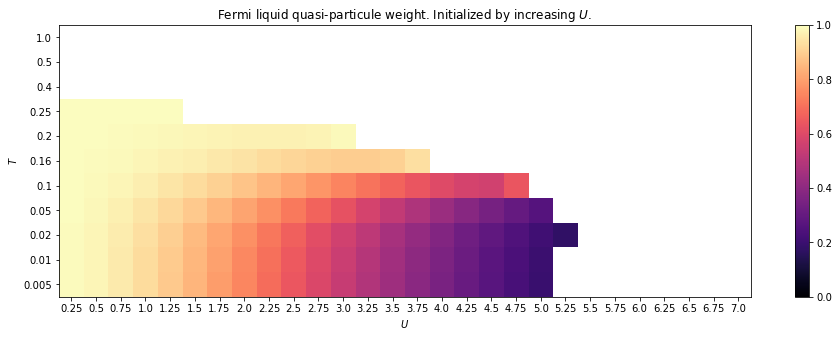

In [389]:
plt.figure(figsize=(16,5))
plt.imshow(Z_increasingU, vmax=1, vmin=0, cmap='magma', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("Fermi liquid quasi-particule weight. Initialized by increasing $U$.");

Let's verify that, when phases coïncide, the quasi-particules weights are equal :

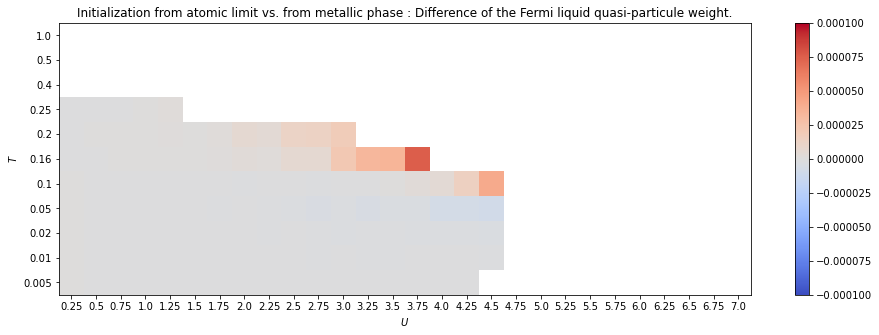

In [24]:
plt.figure(figsize=(16,5))
plt.imshow(Z_from_atomiclim - Z_increasingU, vmin=-0.0001, vmax=0.0001, cmap='coolwarm', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("Initialization from atomic limit vs. from metallic phase : Difference of the Fermi liquid quasi-particule weight.")
plt.savefig("diff-Zat-ZincU.pdf", bbox_inches='tight')

Nice !

### Scanning by decreasing $U$, no $\mathrm{i}\omega_n$ sym. constraint, no $\Re\mathfrak{e}\ G_\text{loc}(\mathrm{i}\omega_n)$ constraint

In [12]:
U_s = np.flip(np.linspace(0.25,7,28))
β_s = [1,2,2.5,4,5,6.25,10,20,50,100,200]
Z_decreasingU = np.zeros((len(β_s),len(U_s)))
norm1_real = np.zeros((len(β_s),len(U_s)))
n_max = 300

for i,β in enumerate(β_s):
    n = np.arange(-n_max,+n_max)
    iωn = 1j*ωn(β,n)
    Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)
    for u,U in enumerate(U_s):
        filename = "data_bethe_decreasingU/U{}-beta{}.npz".format(U,β)
        if os.path.exists(filename):
            f = np.load(filename)
            _, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']
            norm1_real[i,u] = np.linalg.norm(np.real(Gloc_iωn),ord=1)
        else:
            _, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0, γ=0.9, conv_thresh=1e-4)
            np.savez(filename, n=n, iwn=iωn, Gloc=Gloc_iωn, Sigmaloc=Σloc_iωn)
        Gloc_iωn_0 = np.copy(Gloc_iωn)
        Z_decreasingU[i,u] = quasipart_z (iωn, Σloc_iωn)

U_s = np.flip(U_s)
Z_decreasingU = np.fliplr(Z_decreasingU)
norm1_real = np.fliplr(norm1_real)

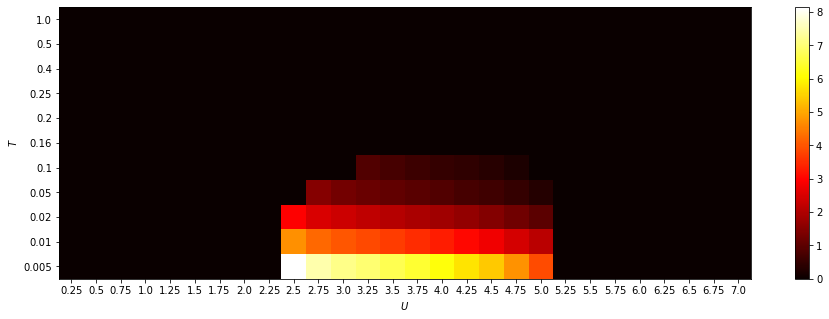

In [13]:
plt.figure(figsize=(16,5))
plt.imshow(norm1_real, cmap='hot', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$");

Oh. That's bad. We'll not try to correct thing, and rather recompute the whole thing with symmetry constraints.

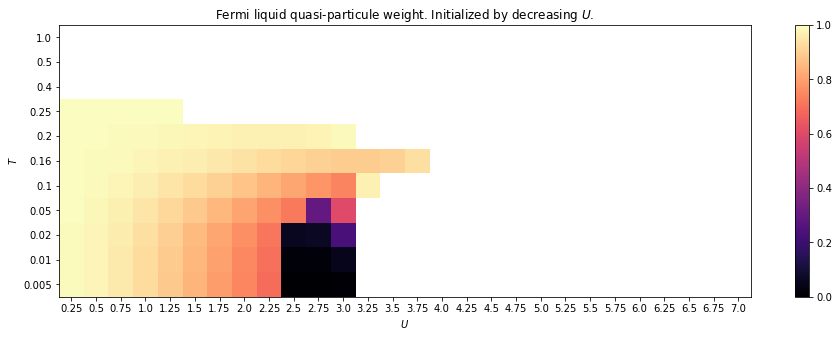

In [14]:
plt.figure(figsize=(16,5))
plt.imshow(Z_decreasingU, vmax=1, vmin=0, cmap='magma', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("Fermi liquid quasi-particule weight. Initialized by decreasing $U$.");

### Scanning by decreasing $U$, $\mathrm{i}\omega_n$ sym. enforced, $\Re\mathfrak{e}\ G_\text{loc}(\mathrm{i}\omega_n)=0$ enforced

In [15]:
U_s = np.flip(np.linspace(0.25,8,32))
β_s = [1,2,2.5,4,5,6.25,10,20,50,100,200]
Z_decreasingU = np.zeros((len(β_s),len(U_s)))
norm1_real = np.zeros((len(β_s),len(U_s)))
n_max = 300

for i,β in enumerate(β_s):
    n = np.arange(-n_max,+n_max)
    iωn = 1j*ωn(β,n)
    Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)
    for u,U in enumerate(U_s):
        filename = "data_bethe_decreasingU_sym_noRe/U{}-beta{}.npz".format(U,β)
        if os.path.exists(filename):
            f = np.load(filename)
            _, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']
            norm1_real[i,u] = np.linalg.norm(np.real(Gloc_iωn),ord=1)
        else:
            print(β,U)
            _, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0,
                                                       γ=1.25, conv_thresh=1e-4,
                                                       discard_real_part=0.8, IPT_dτ=5e-3, internal_halfiωn=True,
                                                       callback=cb_print_delta)
            np.savez(filename, n=n, iwn=iωn, Gloc=Gloc_iωn, Sigmaloc=Σloc_iωn)
        Gloc_iωn_0 = np.copy(Gloc_iωn)
        Z_decreasingU[i,u] = quasipart_z (iωn, Σloc_iωn)

U_s = np.flip(U_s)
Z_decreasingU = np.fliplr(Z_decreasingU)
norm1_real = np.fliplr(norm1_real)

In [16]:
np.max(norm1_real)

1.4456943016206535e-13

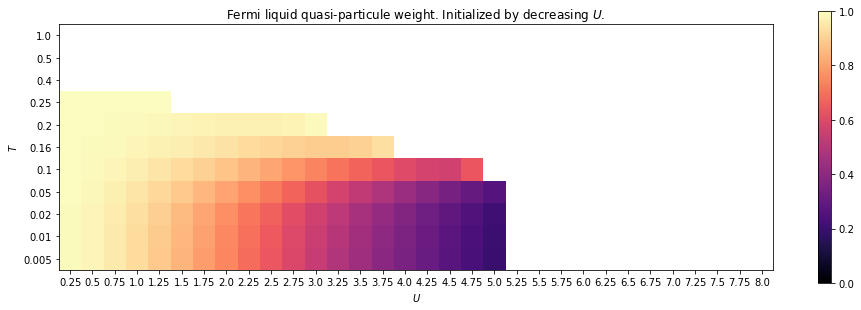

In [17]:
plt.figure(figsize=(16,5))
plt.imshow(Z_decreasingU, vmax=1, vmin=0, cmap='magma', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("Fermi liquid quasi-particule weight. Initialized by decreasing $U$.");

### Scanning by increasing $U$, $\mathrm{i}\omega_n$ sym. enforced, $\Re\mathfrak{e}\ G_\text{loc}(\mathrm{i}\omega_n)=0$ enforced

In [18]:
np.linspace(0.25,8,32)
β_s = [1,2,2.5,4,5,6.25,10,20,50,100,200]
Z_increasingU = np.zeros((len(β_s),len(U_s)))
ΣlocL1_increasingU = np.zeros((len(β_s),len(U_s)))
Σlocat200 = np.zeros((len(β_s),len(U_s)))
n_max = 300

for i,β in enumerate(β_s):
    n = np.arange(-n_max,+n_max)
    iωn = 1j*ωn(β,n)
    Gloc_iωn_0 = G0_loc_iωn(latt_Bethe_hilbert, iωn, 0)
    for u,U in enumerate(U_s):
        filename = "data_bethe_increasingU_sym_noRe/U{}-beta{}.npz".format(U,β)
        if os.path.exists(filename):
            f = np.load(filename)
            _, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']
        else:
            print(β,U)
            _, Gloc_iωn, Σloc_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn_0,
                                                       γ=1.25, conv_thresh=1e-4,
                                                       discard_real_part=0.8, IPT_dτ=5e-3, internal_halfiωn=True,
                                                       callback=cb_print_delta)
            np.savez(filename, n=n, iwn=iωn, Gloc=Gloc_iωn, Sigmaloc=Σloc_iωn)
        Gloc_iωn_0 = np.copy(Gloc_iωn)
        Z_increasingU[i,u] = quasipart_z (iωn, Σloc_iωn)
        ΣlocL1_increasingU[i,u] = np.linalg.norm(np.imag(Σloc_iωn),ord=1)
        Σlocat200[i,u] = np.imag(Σloc_iωn)[250]

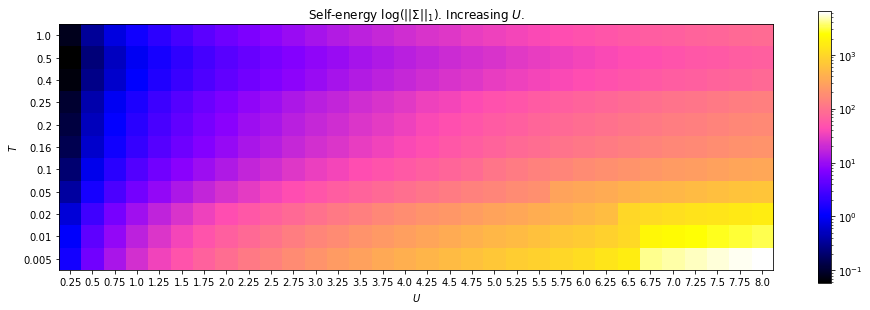

In [19]:
plt.figure(figsize=(16,5))
plt.imshow(ΣlocL1_increasingU, cmap='gnuplot2', norm=mpl.colors.LogNorm(), origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title(r"Self-energy $\log(||\Sigma||_1)$. Increasing $U$.");

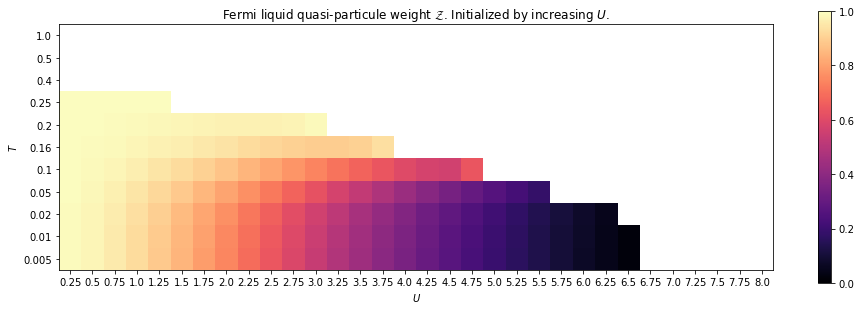

In [21]:
plt.figure(figsize=(16,5))
plt.imshow(Z_increasingU, vmax=1, vmin=0, cmap='magma', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.title("Fermi liquid quasi-particule weight $\mathcal{Z}$. Initialized by increasing $U$.")
plt.savefig("quasipart-Z-incrU.pdf", bbox_inches='tight')

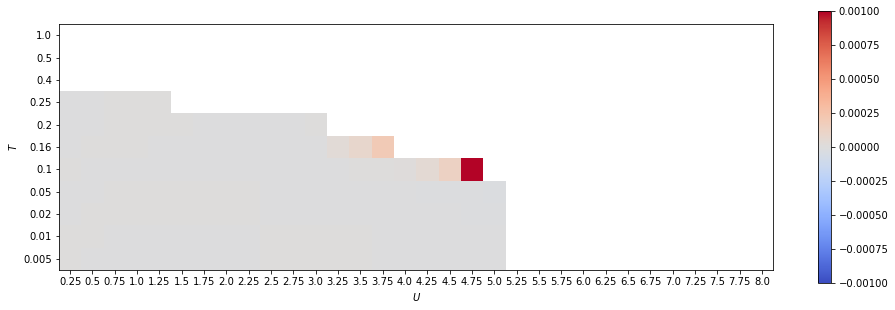

In [51]:
plt.figure(figsize=(16,5))
plt.imshow(Z_decreasingU - Z_increasingU, vmin=-0.001, vmax=0.001, cmap='coolwarm', origin='upper')
plt.colorbar()
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$");

### The phase diagram

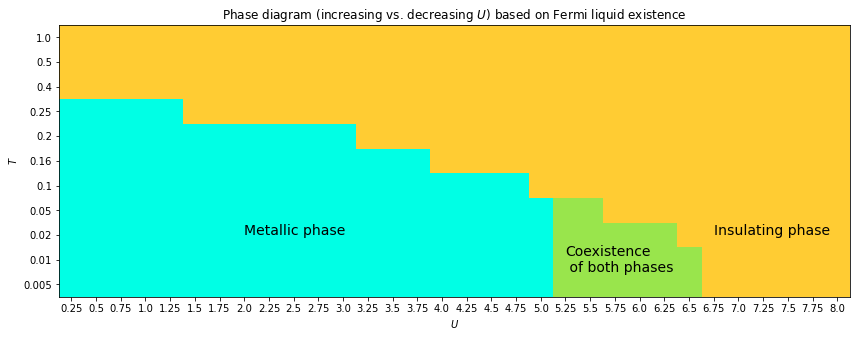

In [52]:
#Z_right = Z_increasingU[:,:-4]
#Z_left = Z_from_atomiclim

#Z_right = Z_from_metal
#Z_left = Z_from_atomiclim

Z_right = Z_increasingU
Z_left = Z_decreasingU

#Z_right = Z_from_metal
#Z_left = Z_decreasingU[:,:-4]

PhaseDiagram = np.where(~np.isnan(Z_right), 0, 1)
PhaseDiagram = np.where(np.isnan(Z_left) & ~np.isnan(Z_right), 2, PhaseDiagram)

plt.figure(figsize=(16,5))
colors_phase_diagram = [(0,1,0.9),(1,0.8,0.2),(0.6,0.9,0.3)]
plt.imshow(PhaseDiagram, origin='upper', cmap=mpl.colors.ListedColormap(colors_phase_diagram))
if False:
    X,Y = np.meshgrid(np.arange(len(U_s)),np.arange(len(β_s)))
    cs = plt.contourf(X, Y, PhaseDiagram, hatches=['', '/'], extend='both', levels=[1.5,2.5])
    for c in cs.collections:
        c.set_color('none') 
    cs.collections[1].set_edgecolor('white')
    cs.collections[1].set_linewidth(0)
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.text(7, 8, "Metallic phase", size=14)
plt.text(26, 8, "Insulating phase", size=14)
plt.text(20, 9.5, "Coexistence\n of both phases", size=14)
plt.title("Phase diagram (increasing vs. decreasing $U$) based on Fermi liquid existence");

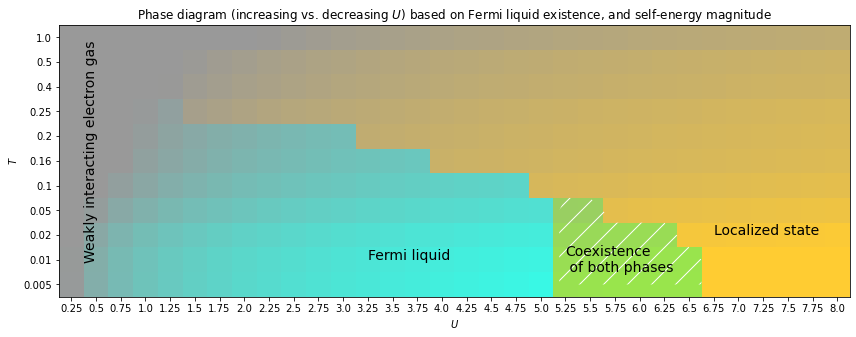

In [53]:
PhaseDiagram_nuanced = np.zeros((PhaseDiagram.shape[0],PhaseDiagram.shape[1],3))
Satmap = Σlocat200 / np.max(Σlocat200)
Satmap = np.log(Satmap)+8
Satmap = np.maximum(0,np.minimum(Satmap,7))
Satmap /= np.max(Satmap)
for u in range(len(U_s)):
    for i in range(len(β_s)):
        r,g,b = colors_phase_diagram[ PhaseDiagram[i,u] ]
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        s *= Satmap[i,u]
        l = 0.6
        r,g,b = colorsys.hls_to_rgb(h,l,s)
        PhaseDiagram_nuanced[i,u,:] = [r,g,b]

plt.figure(figsize=(16,5))
plt.imshow(PhaseDiagram_nuanced, origin='upper')
X,Y = np.meshgrid(np.arange(len(U_s)),np.arange(len(β_s)))
cs = plt.contourf(X, Y, PhaseDiagram, hatches=['', '/'], extend='both', levels=[1.5,2.5])
for c in cs.collections:
    c.set_color('none') 
cs.collections[1].set_edgecolor('white')
cs.collections[1].set_linewidth(0)
plt.xticks(ticks=range(len(U_s)), labels=U_s)
plt.xlabel("$U$")
plt.yticks(ticks=range(len(β_s)), labels=1/np.array(β_s))
plt.ylabel("$T$")
plt.text(12, 9, "Fermi liquid", size=14)
plt.text(26, 8, "Localized state", size=14)
plt.text(20, 9.5, "Coexistence\n of both phases", size=14)
plt.text(0.5, 9, "Weakly interacting electron gas", size=14, rotation=90)
plt.title("Phase diagram (increasing vs. decreasing $U$) based on Fermi liquid existence, and self-energy magnitude")
plt.savefig("phase-diagram.pdf")

### Just some plotting

In [195]:
def plot_res_file (U,β,dataname):
    f = np.load("data_"+dataname+"/U{}-beta{}.npz".format(U,β))
    iωn, Gloc_iωn, Σloc_iωn = f['iwn'], f['Gloc'], f['Sigmaloc']

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,4))
    plot_Giωn(ax1, Gloc_iωn, "G_\operatorname{loc}")
    plot_Giωn(ax2, Σloc_iωn, "\Sigma_\operatorname{loc}", twinx_im=True)
    fig.suptitle(dataname+r", $U={}, \beta={}$".format(U,β))
    fig.tight_layout()
    
    return iωn, Gloc_iωn, Σloc_iωn

L1delta 9.979421555783574e-08 ; deriv0  0.0003550667558731754


nan

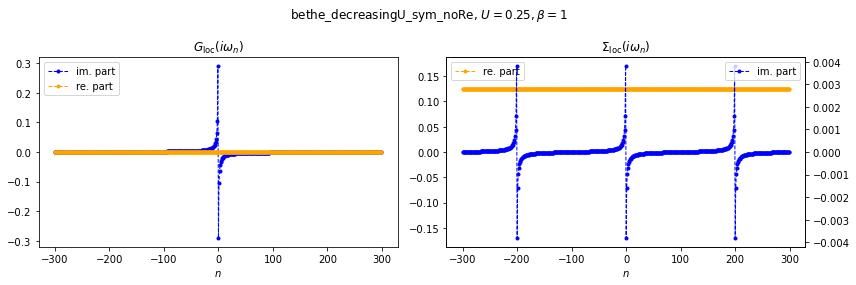

In [211]:
U=0.25
β=1

iωn, Gloc_iωn, _ = plot_res_file(U, β, dataname="bethe_decreasingU_sym_noRe")
_, _, Σloc_metal_iωn, _ = DMFT_loop_Gloc (β, U, latt_Bethe_R, Gloc_iωn, γ=1.3, conv_thresh=1e-5, callback=cb_print_delta)
quasipart_z (iωn, Σloc_metal_iωn)